In [1]:
import sys, time, argparse, matplotlib.pyplot as plt
import torch, einops, sidechainnet as scn, numpy as np
import torch.nn as nn, torch.optim as optim, torch.nn.functional as F

from math import pi
from tqdm.notebook import tqdm
from collections import defaultdict

from einops import rearrange
from einops.layers.torch import Rearrange
from torch.distributions import VonMises

from vit import MAE
from os.path import exists
from resnet import ResNet
from utils import get_seq_features, CropsDataset, load_checkpoint
device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
# Load CASP7 data as pytorch tensors
data = scn.load(scn_dir='../data/', casp_version=12, with_pytorch="dataloaders", 
                seq_as_onehot=True, aggregate_model_input=False, 
                batch_size=1, dynamic_batching=True)

SidechainNet was loaded from ../data/sidechainnet_casp12_30.pkl.


In [3]:
class testStats:
    '''Aggregate the statistics for all the test proteins
       Print out overall stats for top L, L/2, L/5 predictions,
       which are denoted as k=1, k=2, k=5.
       Also print prec/recall for all predictions (above dist 1), dentoed k=0
    '''
    
    def __init__(self):
        '''precision by pid, length, Lk'''
        self.prec = defaultdict(lambda: defaultdict(dict)) #nested dict
        
    def print_stats(self):
        '''print per protein precision, and compute stats over all pids'''
        prec_Lk = defaultdict(lambda: defaultdict(list))
        for pid in self.prec.keys():
            for len_lbl in self.prec[pid].keys():
                for k in self.prec[pid][len_lbl].keys():
                    prec_Lk[len_lbl][k].append(self.prec[pid][len_lbl][k])
                    print("Protein:", pid, len_lbl, k, self.prec[pid][len_lbl][k])
                    
        print("\nOverall Stats:")
        for len_lbl in prec_Lk:
            for k in prec_Lk[len_lbl]:
                if k >= 1:
                    precs = [p for (p, n, l) in prec_Lk[len_lbl][k]]
                    print(len_lbl, k, np.array(precs).mean())
                else:
                    precs = [p for (p, r, nc, np, nt) in prec_Lk[len_lbl][k]]
                    recs = [r for (p, r, nc, np, nt) in prec_Lk[len_lbl][k]]
                    print(len_lbl, k, np.array(precs).mean(), np.array(recs).mean())
                
   
    def compute_lk(self, len_lbl, cmaps_pred, cmaps_true, lb, ub, pids, lengths):
        '''Compute the precision (and recall) for given length range between
        [lb, ub], for the top L/k predictions.
        '''
        
        # create a mask for only those i,j pairs that are within [lb, ub] band
        N = cmaps_pred.shape[1]
        ones = torch.ones((N, N))
        sep_mask = torch.triu(ones, diagonal=lb) * torch.tril(ones, diagonal=ub)
        sep_mask = sep_mask.to(device)
                
        # filter out elements not in the lb, ub diagional band
        cmaps_pred = cmaps_pred * sep_mask
        cmaps_true = cmaps_true * sep_mask
        
        # compute stats for each protein in the batch
        for pi in range(len(pids)):
            pid = pids[pi]
            L = lengths[pi]
            cmap_p = cmaps_pred[pi] # predicted probabilities
            cmap_t = cmaps_true[pi] # true binary cmap
            cmap_b = torch.where(cmap_p > 0.5, 1, 0) # predicted binary cmap
            
            for k in [1, 2, 5]:
                # choose smaller of L/k or # true contacts
                #Lk = min(L//k, int(cmap_t.sum()))
                Lk = L // k
                
                # next, find the probabilities over 0.5, extract topk of those
                # and return a tuple that contains the positions of the topk vals
                idxs = torch.where(cmap_p > 0.5)
                probs = cmap_p[idxs]
                
                topk_probs = torch.topk(probs, min(Lk, len(probs)))
                top_Lk = topk_probs.indices
                    
                top_tup = (idxs[0][top_Lk], idxs[1][top_Lk])

                # the number of contacts common to both pred and true
                num_correct = torch.sum(cmap_b[top_tup] * cmap_t[top_tup])
                
                # compute precision @ L/k
                prec_Lk = num_correct / Lk
                    
                self.prec[pid][len_lbl][k] = (float(prec_Lk.cpu()), 
                                              int(num_correct.cpu()), Lk)
            
            # for the full protein, compute precision and recall
            if len_lbl == 'all':
                k = 0 # let k =0 mean no topk restriction
                num_correct = torch.sum(cmap_b * cmap_t)
                num_true = torch.sum(cmap_t)
                num_preds = torch.sum(cmap_b)
                
                num_correct = num_correct * 0 if num_preds == 0 else num_correct
                num_preds = 1 if num_preds == 0 else num_preds
                
                self.prec[pid][len_lbl][k] = (float(num_correct/num_preds), 
                                              float(num_correct/num_true), 
                                              int(num_correct), int(num_preds), 
                                              int(num_true))
            
                
    def update(self, cmaps, cnts, dmaps, dmap_masks, pids, lengths, dist_bins):
        '''Take the predicted contact map probabilities for all pids in a 
        batch, and compute the precision (and recall) for various length
        thresholds -- short, medium, long -- and overall
        '''
        # move dist bins (f) last
        cmaps = einops.rearrange(cmaps, 'b f i j -> b i j f')
        cnts = cnts * dmap_masks[:, :cnts.size(1), :cnts.size(1)] # ignore any invalid ij pair
        cmaps = cmaps * dmap_masks[:, :cnts.size(1), :cnts.size(1)].unsqueeze(dim=3) # ignore the preds at invalid pos
        
        # divide cmaps by cnts, but make sure to not divide by 0
        cnts_mask = torch.where(cnts > 0)
        cmaps[cnts_mask] = cmaps[cnts_mask] / cnts[cnts_mask].unsqueeze(dim=1)
        
        # now make dist bins sum up to one (prob vector) by dividing the 
        # bins with the sum of all bins
        cmaps_sum = cmaps.sum(dim=3, keepdim=True)
        cmaps[cnts_mask] = cmaps[cnts_mask] / cmaps_sum[cnts_mask]

        #now create cmap prob for all dists under 8A
        bin8 = torch.searchsorted(dist_bins.contiguous(), 8).item()  # which bin for 8A
        cmaps_pred = cmaps[:, :, :, :bin8].sum(dim=3)
        
        #create true cmap, and retain only valid pos
        cmaps_true = torch.where(dmaps[:, :cnts.size(1), :cnts.size(1)] <= bin8, 1, 0) * dmap_masks[:, :cnts.size(1), :cnts.size(1)]
    
        # short, medium, long range contacts
        N = cmaps_true.shape[1]
        ranges = {'short':(6,11), 'medium':(12,23), 'long':(24, N), 'all':(2,N)}
        for len_lbl in ['short', 'medium', 'long', 'all']:
            lb, ub = ranges[len_lbl]
            self.compute_lk(len_lbl, cmaps_pred, cmaps_true, lb, ub, pids, lengths)

In [4]:
#model = ResNet(41, 64, 1, num_blks=8, dropout=0.1).to(device)

model = MAE(
            in_channels=41, out_channels=64, encoder_dim=64, decoder_dim=64,
            encoder_mlp_dim=1, encoder_depth=1, encoder_heads=1, encoder_dim_head=32, encoder_dropout=0.5,
            decoder_mlp_dim=1, decoder_depth=1, decoder_heads=1, decoder_dim_head=32, decoder_dropout=0.5,
            patch_size=16, pos_max_len=1000
        ).to(device)

optimizer = optim.Adam(model.parameters(), lr = 4e-6, amsgrad=True)

fname = "fold_vit.pth" if type(model) == MAE else "fold_resnet.pth"
if exists(fname) and fname != "":
    last_epoch, last_bidx, loss, model, optimizer = load_checkpoint(fname, model, optimizer, device)
        
model = nn.DataParallel(model)
loss 

1.893719934589456

In [5]:
model.eval()

test_stats = testStats()

with torch.no_grad():
    running_loss, running_len = 0, 1
    
    tester = tqdm(enumerate(data['valid-90']), 
                   total=len(data['valid-90']), unit='batch')
    
    tester.set_description(f'Testing')
    
    for bidx, batch in tester:
        seqs, evos, angs, dmaps, msks, cmaps, pids, lengths = get_seq_features(batch)
        
        testset = CropsDataset(
            seqs, evos, angs, dmaps, msks, cmaps, pids,
            crop_sz=64, stride_sz=32, bins_sz=64, angs_sz=1295, 
            batch_sz=torch.cuda.device_count() * 64, test=True
        )
        
        for cidx, (feats, angs, dmaps, dmsks, ij_pos) in enumerate(testset):
            feats = feats.to(device)
            dmaps, dmsks = dmaps.to(device), dmsks.to(device)

            dmaps_pred = model(feats)
            testset.add_pred_crop(dmaps_pred, ij_pos)

            # compute entropy loss per crop element
            loss = F.cross_entropy(dmaps_pred, dmaps, reduction='none')
            
            # consider only valid positions based on crop_mask
            loss = torch.sum(loss * dmsks) / feats.size(0)

            running_loss += loss.item() * feats.size(0) # total loss
            running_len += torch.sum(dmsks).item()
            
        tester.set_postfix(loss = running_loss / running_len)
        
        cmaps, cnts, _ = testset.get_cmap_data()
        dmaps, dmap_masks = testset.get_dmat_data()
        dist_bins = testset.get_dist_bins()
        
        test_stats.update(cmaps.to(device), cnts.to(device), dmaps.to(device), dmap_masks.to(device), pids, lengths, dist_bins)

  0%|          | 0/32 [00:00<?, ?batch/s]

In [6]:
test_stats.print_stats()

Protein: 90#2K2I_2_B short 1 (1.0, 20, 20)
Protein: 90#2K2I_2_B short 2 (1.0, 10, 10)
Protein: 90#2K2I_2_B short 5 (1.0, 4, 4)
Protein: 90#2K2I_2_B medium 1 (0.6500000357627869, 13, 20)
Protein: 90#2K2I_2_B medium 2 (1.0, 10, 10)
Protein: 90#2K2I_2_B medium 5 (1.0, 4, 4)
Protein: 90#2K2I_2_B long 1 (0.0, 0, 20)
Protein: 90#2K2I_2_B long 2 (0.0, 0, 10)
Protein: 90#2K2I_2_B long 5 (0.0, 0, 4)
Protein: 90#2K2I_2_B all 1 (1.0, 20, 20)
Protein: 90#2K2I_2_B all 2 (1.0, 10, 10)
Protein: 90#2K2I_2_B all 5 (1.0, 4, 4)
Protein: 90#2K2I_2_B all 0 (1.0, 0.35087719559669495, 60, 60, 171)
Protein: 90#4PVZ_2_C short 1 (0.04651162773370743, 2, 43)
Protein: 90#4PVZ_2_C short 2 (0.095238097012043, 2, 21)
Protein: 90#4PVZ_2_C short 5 (0.25, 2, 8)
Protein: 90#4PVZ_2_C medium 1 (0.09302325546741486, 4, 43)
Protein: 90#4PVZ_2_C medium 2 (0.190476194024086, 4, 21)
Protein: 90#4PVZ_2_C medium 5 (0.5, 4, 8)
Protein: 90#4PVZ_2_C long 1 (0.04651162773370743, 2, 43)
Protein: 90#4PVZ_2_C long 2 (0.095238097012043,

  0%|          | 0/32 [00:00<?, ?batch/s]

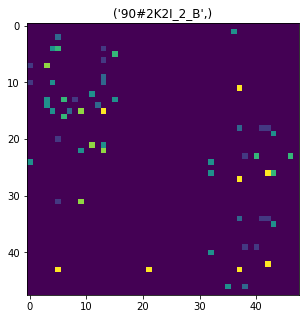

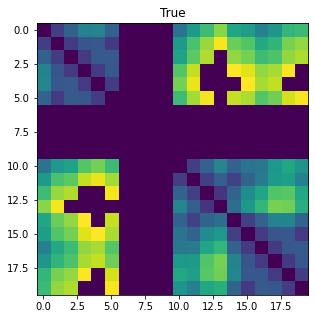

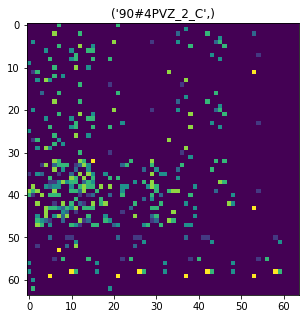

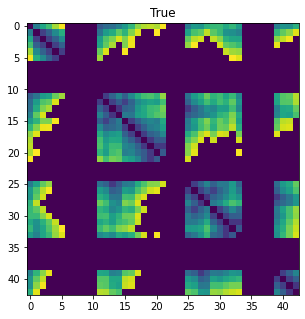

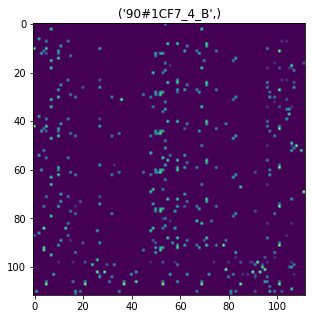

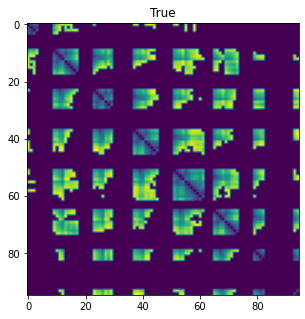

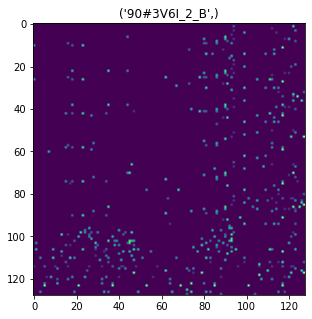

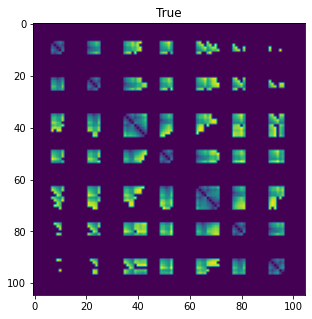

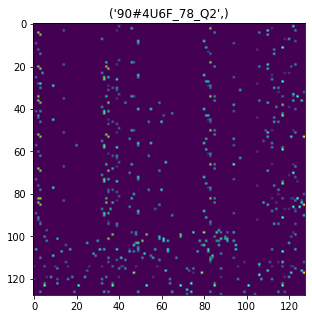

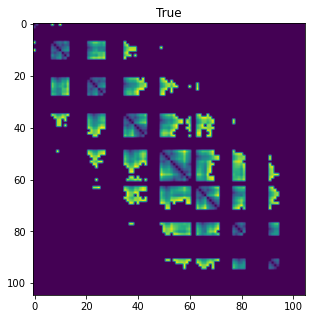

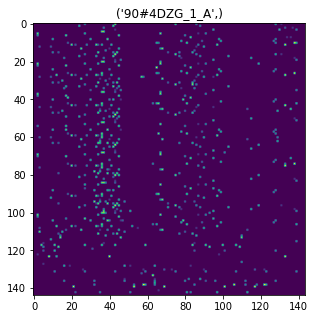

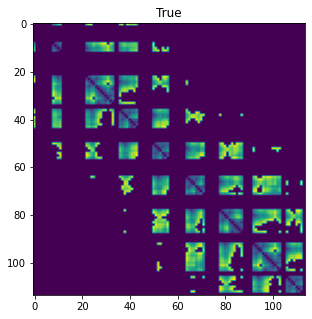

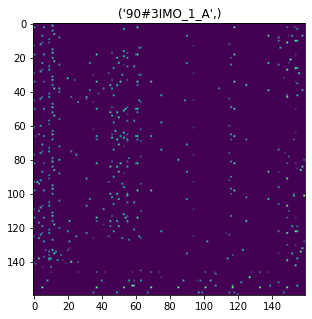

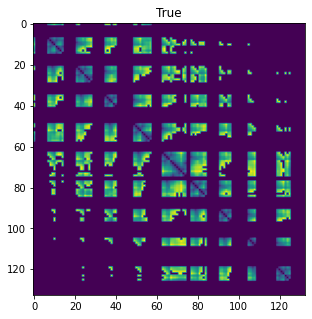

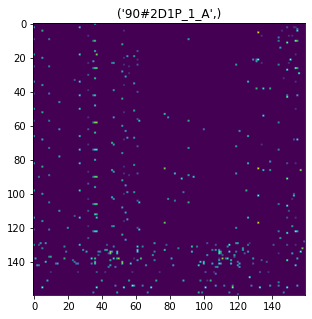

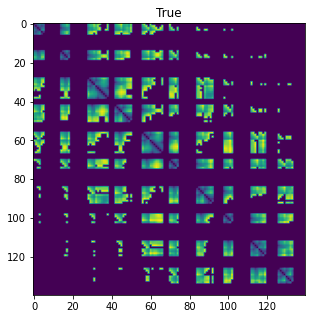

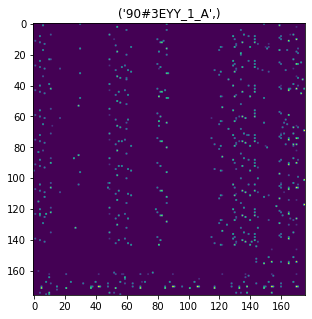

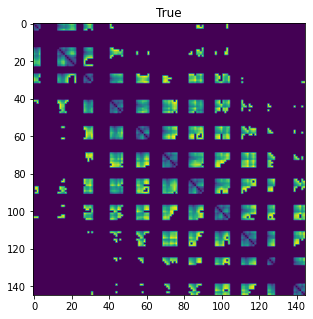

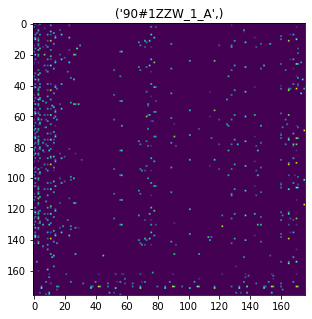

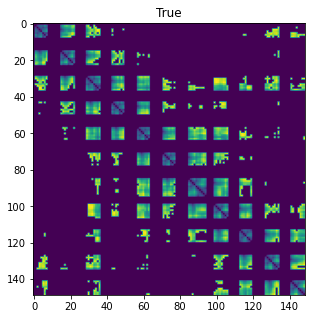

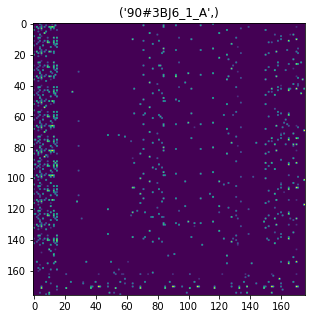

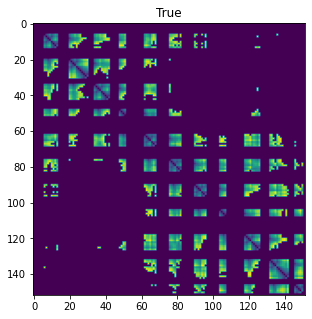

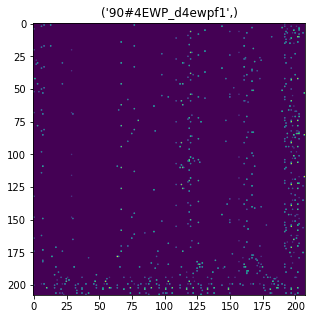

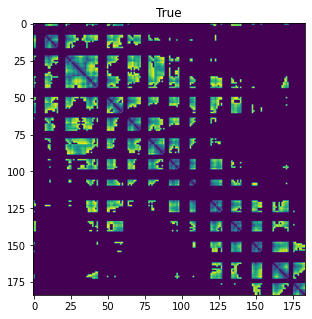

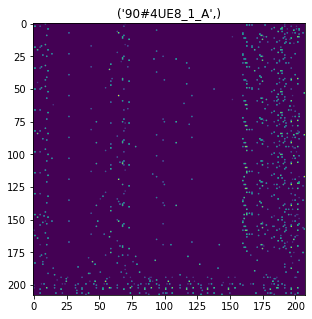

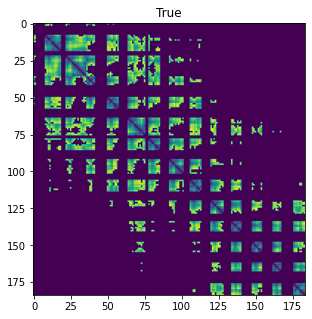

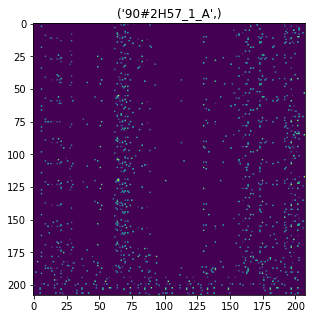

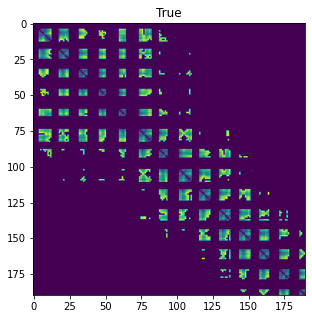

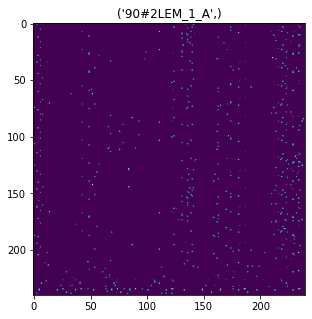

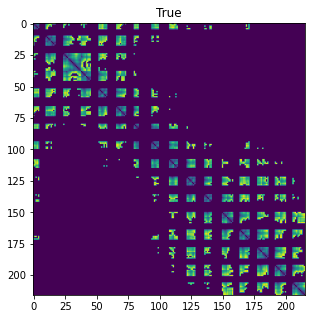

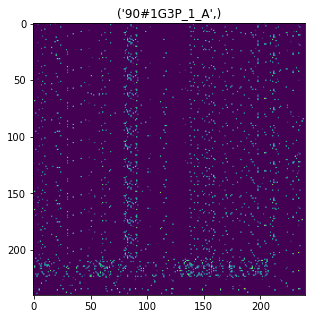

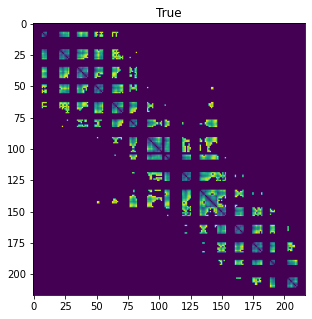

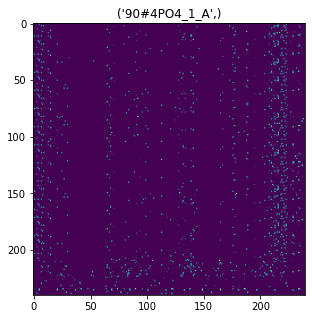

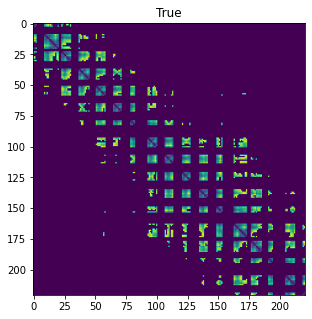

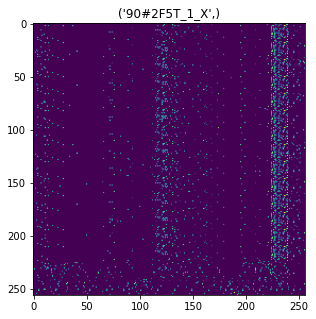

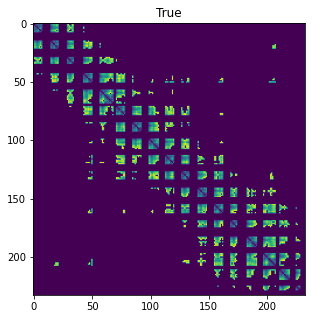

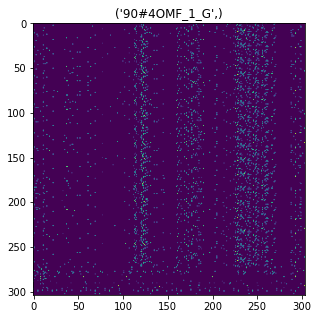

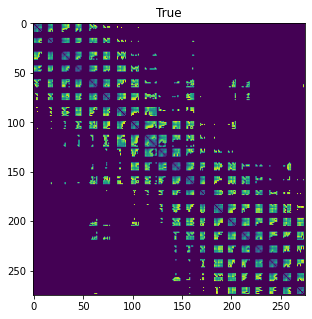

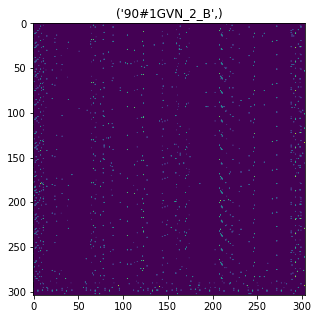

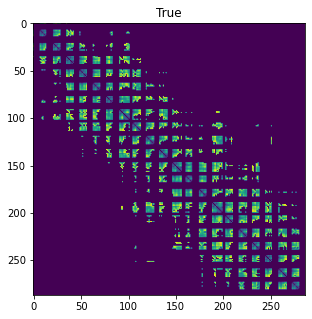

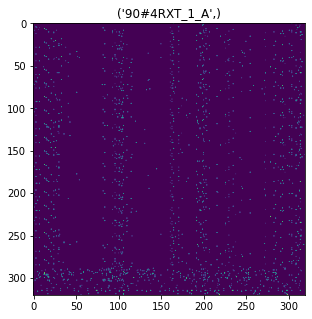

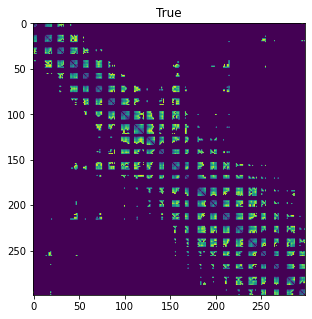

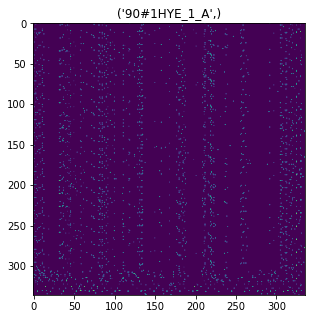

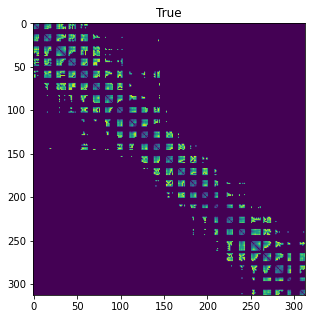

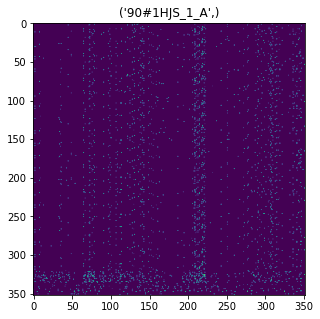

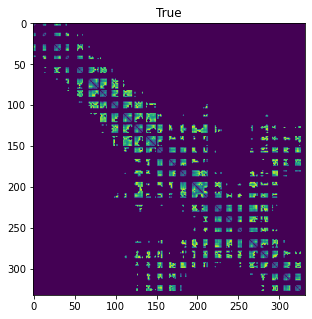

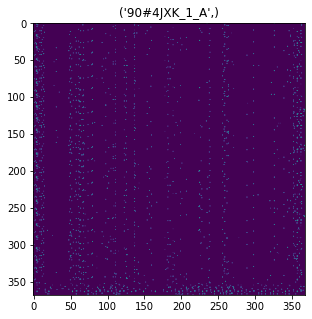

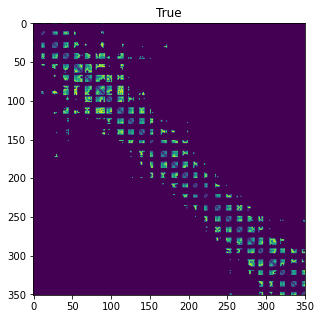

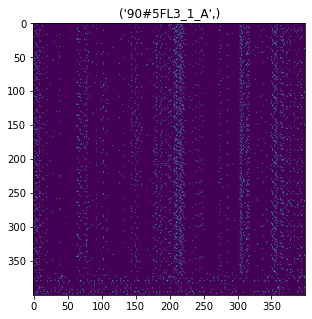

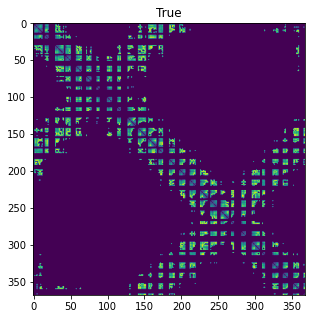

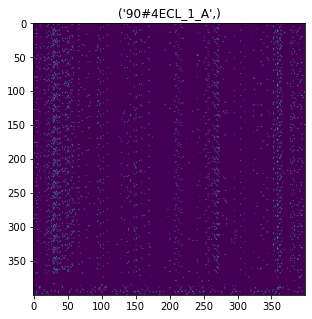

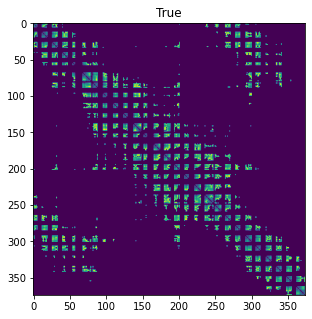

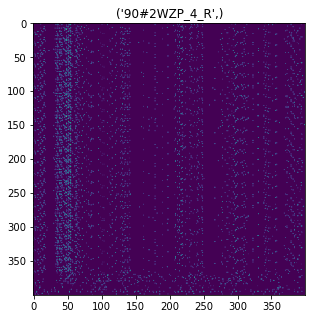

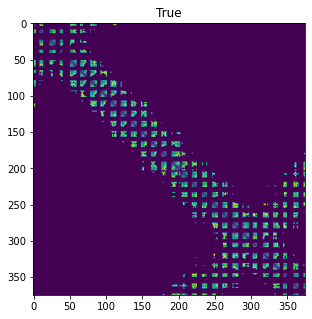

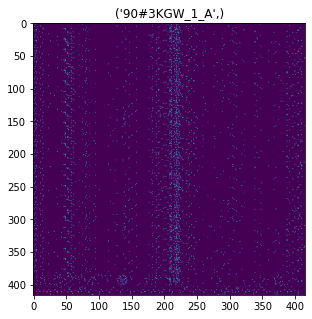

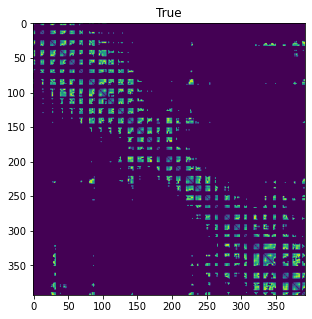

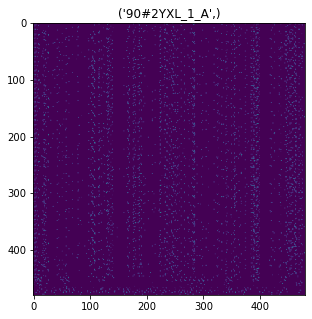

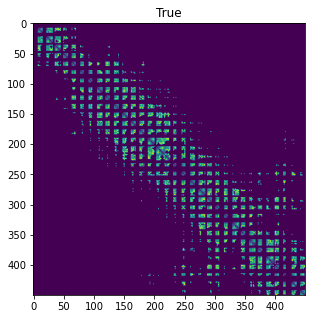

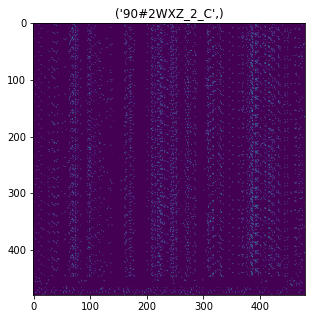

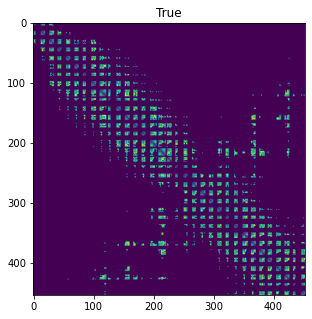

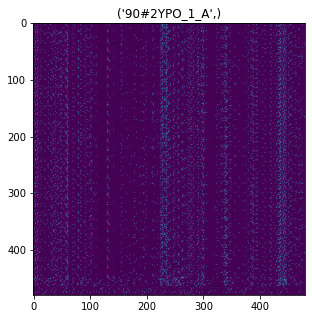

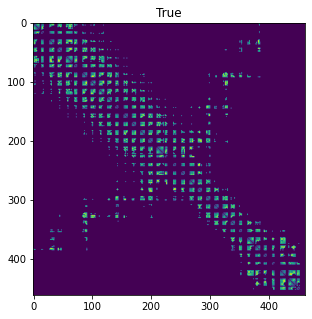

RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/gpfs/u/home/HPDM/HPDMphmb/scratch/AI-CONDA/lib/python3.9/site-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/gpfs/u/home/HPDM/HPDMphmb/scratch/AI-CONDA/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1129, in _call_impl
    return forward_call(*input, **kwargs)
  File "/gpfs/u/scratch/HPDM/HPDMphmb/alphafold1/vit.py", line 227, in forward
    x = x + self._p_embed[:, :x.size(1)]
RuntimeError: The size of tensor a (1296) must match the size of tensor b (1000) at non-singleton dimension 1


In [7]:
model.eval()

with torch.no_grad():
    running_loss, running_len = 0, 1
    
    tester = tqdm(enumerate(data['valid-90']), 
                   total=len(data['valid-90']), unit='batch')
    
    tester.set_description(f'Testing')

    for bidx, batch in tester:
        seqs, evos, angs, dmaps, msks, cmaps, pids, lengths = get_seq_features(batch)
        
        testset = CropsDataset(
            seqs, evos, angs, dmaps, msks, cmaps, pids,
            crop_sz=16, stride_sz=32, bins_sz=65, angs_sz=1295, 
            batch_sz=64, test=True
        )

        feats = torch.cat([testset.seqs, testset.evos], dim = 1).to(device)
        
        dmaps_pred = model(feats)
             
        dmaps_pred = torch.max(torch.softmax(dmaps_pred, dim = 1), 1)[1]
        
        shape = dmaps_pred.shape
        
        dmaps_pred = dmaps_pred.reshape(-1)
        dist_bins = testset.get_dist_bins()
        
        for i in range(dmaps_pred.size(0)):
            dmaps_pred[i] = dist_bins[dmaps_pred[i]]
                
        dmaps_pred = dmaps_pred.reshape(shape)
        plt.figure(figsize=(5, 5))
        plt.title(pids)
        plt.imshow(dmaps_pred.cpu()[0])
        plt.show()
        
        plt.figure(figsize=(5, 5))
        plt.title("True")
        plt.imshow(cmaps[0])
        plt.show()